In [2]:
import os
import sys
sys.path.append("/home/ramanav/Projects/Ink-WSI")
from pathlib import Path

import pandas as pd
import numpy as np
import torchvision
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchmetrics
import pickle as pkl
import matplotlib

from modules.patch_extraction import SedeenAnnotationParser, ExtractAnnotations
from modules.deploy import Pairwise_ExtractAnnot
from modules.train_filter import InkGenerator, Handwritten
import trainer
from modules import train_filter
from modules.metrics import ssim, psnr, mse, pbvif

sys.path.append("/amartel_data4/temp/lukasz_test/blur/")
from dptools.slides.processing.wsimask import WSIMask



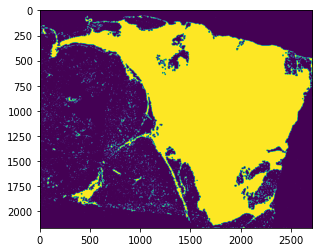

In [12]:
# testing mask generator on the dcis dataset
wsipth = "/amartel_data4/Flow/DCIS_prediction/DCIS_unknown/104131.svs"
tissue_mask = WSIMask(wsipth, min_size=500, mode="lab", threshold=0.1,fill_mask_kernel_size=9)

plt.imshow(tissue_mask.array.T)
plt.show()

In [87]:
def log_results(template, all_patch_results, output_dir, wsi_name):
    """
    Plots heatmap of tumourbed and TIL score
    """
    template = template.astype(np.float64)
    template[template==0] = np.nan
    fill_tissue = template.flatten().copy()
    fill_tissue[np.where(fill_tissue >= 1)[0]] = all_patch_results
    tissue_heatmap = np.reshape(fill_tissue, np.shape(template))

    cmap = matplotlib.cm.jet
    cmap.set_bad('white',1.)
    # ax.imshow(masked_array, interpolation='nearest', cmap=cmap)
    im_ratio = tissue_heatmap.shape[0] / tissue_heatmap.shape[1]
    plt.figure()
    plt.title("Ink tissue map")
    im = plt.imshow(tissue_heatmap, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, fraction=0.046 * im_ratio, pad=0.04)
    plt.savefig(str(Path(output_dir)/f"{wsi_name}_heatmap.png"))

# MODEL_PATH = '/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_27Jul18_05_09_1.00.pt'
# OUTPUT_DIR = "/home/ramanav/Projects/Ink-WSI/Results/heatmaps"
# device = torch.device("cuda:0")

# model = trainer.Model.create("ink")
# model.load_model_weights(MODEL_PATH,torch.device("cpu"))
# model.to(device)

# ink_slide_path = "/localdisk3/ramanav/02-0484.svs"
# ink_slide_path = "/localdisk3/ramanav/121455.svs"
# ink_slide_path = "/localdisk3/ramanav/02-1693.svs"
# ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121819.svs"
# ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121516.svs"
ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121804.svs"



annotation_dir = str(Path(ink_slide_path).parent / "sedeen")

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"mask":"#0000ffff"}

singledataset = ExtractAnnotations(
        image_pth=ink_slide_path,
        annotation_dir=annotation_dir,
        renamed_label=ink_labelset,
        tile_h=TILE_H,
        tile_w=TILE_W,
        tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
        tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
        spacing=None,
        lwst_level_idx=LWST_LEVEL_IDX,
        mode="train",
        train_split=1,
        transform=TRANSFORM,
        threshold=0.7,
        sample_threshold=10,
        get_template=True
        )

template = singledataset.template.copy()

dataloader = torch.utils.data.DataLoader(singledataset,batch_size=64)

Loading wsis.. 1/1: : 1it [02:41, 161.75s/it]


In [88]:
dataloader = torch.utils.data.DataLoader(singledataset,batch_size=64)

In [75]:
ink_index2 = np.where(np.array(all_patch_results)*1==1)[0]

In [80]:
a = model(torch.unsqueeze(singledataset[idx][0],dim=0).to(device))

In [82]:
torch.nn.functional.softmax(a,dim=1)[:,1]>=0.95

tensor([False], device='cuda:3')

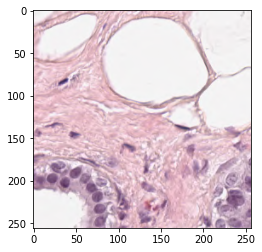

In [76]:
idx = ink_index[26]
plt.imshow(singledataset[idx][0].permute(1,2,0).cpu())

In [89]:
all_patch_results = []
for data in tqdm(dataloader):
    img, label = data
    img = img.to(device)
    outputs = model(img)
    outputs = torch.nn.functional.softmax(outputs,dim=1)
    # _, predicted = torch.max(outputs.data, 1)
    predicted = outputs[:,1]>=0.95
    preds = torch.squeeze(predicted.cpu()).numpy()
    all_patch_results.extend(preds)

100%|██████████| 173/173 [00:23<00:00,  7.22it/s]


In [86]:
OUTPUT_DIR

'/home/ramanav/Projects/Ink-WSI/Results/heatmaps'

/tmp/ipykernel_5806/2234202871.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  cmap.set_bad('white',1.)


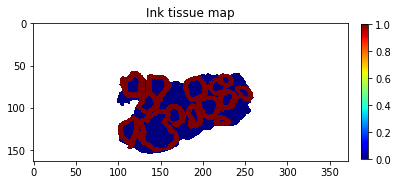

In [90]:
log_results(template,all_patch_results,OUTPUT_DIR,Path(ink_slide_path).stem)

In [49]:
df = pd.read_excel("~/Downloads/pairs.ods")
ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/"
clean_path = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/"

slide_path = [str( Path(ink_slide_path) / (str(df["Ink Slides"][i])+".svs" ) ) for i in range(len(df))]
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}

dataset = ExtractAnnotations(
        image_pth=slide_path[3],
        annotation_dir=annotation_dir,
        renamed_label=ink_labelset,
        tile_h=TILE_H,
        tile_w=TILE_W,
        tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
        tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
        spacing=None,
        lwst_level_idx=LWST_LEVEL_IDX,
        mode="train",
        train_split=1,
        transform=TRANSFORM,
        threshold=0.7,
        sample_threshold=50
        )

Loading wsis.. 1/1: : 1it [00:52, 52.32s/it]


In [50]:
dataset.all_labels

array([0, 0, 0, ..., 1, 1, 1])

In [43]:
label

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [67]:
#Ink filter model
model_path = "/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_27Jul18_05_09_1.00.pt"
# model_path = "/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_28Jul12_19_55_1.00.pt"
device = torch.device("cuda:3")
model = trainer.Model.create("ink")
model.load_model_weights(model_path,torch.device("cpu"))
model.to(device)

cm = torchmetrics.ConfusionMatrix(num_classes=2)
auroc = torchmetrics.AUROC(pos_label=1)

model.eval()
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64)
index = []
ink_index = []
predicts = []
with torch.no_grad():
    for i,data in enumerate(tqdm(dataloader)):
        img, label = data
        img = img.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.squeeze(predicted.cpu())
        predicts.extend(preds.numpy())
        ink_index.extend(64*i + torch.where(preds==1)[0].numpy())
        index.extend(64*i + torch.where(torch.abs(preds-label)==1)[0].numpy())
        soft = torch.nn.functional.softmax(outputs,dim=1).cpu()
        cm(preds,label)
        auroc(soft[:,1],label)

/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
  0%|          | 0/41 [00:00<?, ?it/s]/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████| 41/41 [00:05<00:00,  8.03it/s]


In [73]:
img.shape

torch.Size([25, 3, 256, 256])

In [57]:
dataset.labels

AttributeError: 

In [69]:
predicts = np.array(predicts)

In [71]:
np.sum(np.abs((dataset.all_labels-predicts)))

16

1


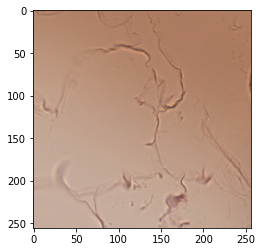

In [64]:
idx = ink_index[3]
plt.imshow(dataset[idx][0].permute(1,2,0))
print(dataset[idx][1])

In [56]:
index

[506,
 517,
 658,
 923,
 929,
 1381,
 1382,
 1823,
 1824,
 1901,
 2153,
 2154,
 2155,
 2156,
 2157,
 2214]

In [54]:
preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])

In [55]:
label

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])

In [53]:
cm.compute()

tensor([[2006,    0],
        [  16,  563]])

In [2]:
from modules.train_filter import Finetune_dataset

In [ ]:
image_pth = "/localdisk3/ramanav/finetune_slides"
TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

Handwritten_obj = 


dataset = Finetune_dataset( 
                 image_pth,
                 handwritten_obj,
                 colors,
                 annotation_dir,
                 renamed_label:dict,
                 tile_h, 
                 tile_w, 
                 tile_stride_factor_h, 
                 tile_stride_factor_w, 
                 spacing=None, 
                 mask_pth=None, 
                 output_pth=None, 
                 lwst_level_idx=0, 
                 mode="train", 
                 train_split=0.8, 
                 threshold=0.7, 
                 transform=None,
                 sample_threshold:int=100,
                 get_template=False)

In [3]:
template = Handwritten(path="/home/ramanav/Projects/Ink_project/Projects/Dataset/by_class",n=500)

Loading the data...


100%|██████████| 500/500 [00:09<00:00, 51.32it/s]


In [4]:
colors = [["black","#28282B"],["#002d04","#2a7e19"],["#000133","skyblue"],["#1f0954","#6d5caf"],["#a90308","#ff000d"],["#005558","#90DCD5"],["#001769","#005CC9"],["#3C1C16","#A05745"]]

ink_generator = InkGenerator(ink_template=template,colors=colors)

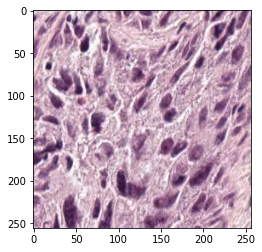

In [22]:
img = singledataset.all_image_tiles_hr[682]
plt.imshow(img)

In [ ]:
crop,color_matrix2,noise_img,mask,flag,alpha = ink_generator.generate(img)

## To do
- Ink filter all metrics calculation (get table)
- Pair wise patch extraction, of ink and non ink areas, mix both sedeen parser and pair wise extractor
- Use pix2pix for ink removal
- Calculate all the image metrics (get table)

In [6]:
df = pd.read_excel("~/Downloads/pairs.ods")
ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/"
clean_path = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/"

## Pair wise patch extraction from annotation 

In [3]:
ink_slide = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
clean_slide = str( Path(clean_path) / (str(df["Clean Slides"][0])+".svs" ) )
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}

# dataset = Pairwise_ExtractAnnot(pair_pths=(clean_slide,ink_slide),
#                                 annotation_dir=annotation_dir,
#                                 renamed_label=ink_labelset,
#                                 tile_h=TILE_H,
#                                 tile_w=TILE_W,
#                                 tile_stride_factor_h=TILE_STRIDE_FACTOR_H, 
#                                 tile_stride_factor_w=TILE_STRIDE_FACTOR_W, 
#                                 lwst_level_idx=LWST_LEVEL_IDX, 
#                                 mode="train", 
#                                 train_split=1, 
#                                 transform=TRANSFORM,
#                                 sample_threshold=30)


# ink_slide = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
# clean_slide = str( Path(clean_path) / (str(df["Clean Slides"][0])+".svs" ) )

pair_list = [(str( Path(clean_path) / (str(df["Clean Slides"][i])+".svs" ) ),str( Path(ink_slide_path) / (str(df["Ink Slides"][i])+".svs" ) ))
                for i in range(len(df))]
# print(pair_list)
# print(pair_list[5])

pairdataset = Pairwise_ExtractAnnot(pair_pths=pair_list[0],
                                annotation_dir=annotation_dir,
                                renamed_label=ink_labelset,
                                tile_h=TILE_H,
                                tile_w=TILE_W,
                                tile_stride_factor_h=TILE_STRIDE_FACTOR_H, 
                                tile_stride_factor_w=TILE_STRIDE_FACTOR_W, 
                                lwst_level_idx=LWST_LEVEL_IDX, 
                                mode="train", 
                                train_split=1, 
                                transform=TRANSFORM,
                                sample_threshold=30)

Loading wsis.. 1/1: : 1it [05:07, 307.11s/it]


Len of pairwise slides: 2859
0


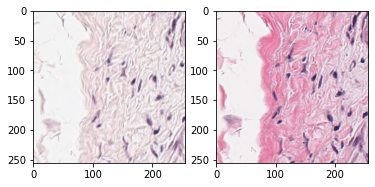

ssim: 0.34867658161469794
psnr: 15.569643477173027
vif: 0.05100916503064483


In [13]:
#Test slides
print(f"Len of pairwise slides: {len(pairdataset)}")

idx = np.random.randint(len(pairdataset))
ink_patch, clean_patch, label_pair = pairdataset[idx]

clean_patch = np.asarray(clean_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)

fig, ax = plt.subplots(1,2)
print(label_pair)
ax[0].imshow(ink_patch)
ax[1].imshow(clean_patch)
plt.show()

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim(clean_patch, ink_patch)
psnr_without_normalization = psnr(clean_patch, ink_patch)
vif_without_normalization = pbvif(clean_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))


In [14]:
from sewar import full_ref
ssim_without_normalization = full_ref.ssim(clean_patch, ink_patch)
psnr_without_normalization = full_ref.psnr(clean_patch, ink_patch)
vif_without_normalization = full_ref.vifp(clean_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))



ssim: (0.22065978250396542, 0.22163304302282624)
psnr: 15.569643477173027
vif: 0.013528376353881795


In [20]:
def is_image(I):
    """
    Is I an image.
    """
    if not isinstance(I, np.ndarray):
        return False
    if not I.ndim == 3:
        return False
    return True


def is_uint8_image(I):
    """
    Is I a uint8 image.
    """
    if not is_image(I):
        return False
    if I.dtype != np.uint8:
        return False
    return True

In [16]:
img = Image.fromarray(ink_patch.astype(np.uint8),mode="RGB")

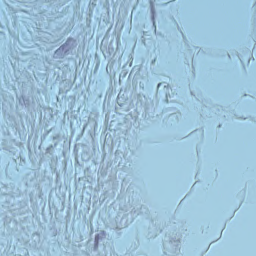

In [19]:
Image.fromarray(ink_patch).convert("RGB")

In [7]:
Image.fromarray(ink_patch).convert("RGB")

AttributeError: type

In [32]:
import staintools
import cv2
from PIL import Image

#Color Normalization
template_img = cv2.cvtColor(cv2.imread("/home/ramanav/Projects/Ink-WSI/modules/register/staintemplate.png"),cv2.COLOR_BGR2RGB)
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(template_img)

In [2]:
import sys
sys.path.append("/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/pyPyrTools/")
from vif_test import vifvec


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Error: image input parameter required.")? (blurDn.py, line 18)

0


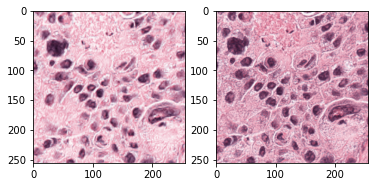

ssim: 0.46089928987953027
psnr: 13.648597792390756
vif: 0.08673784759647742


In [33]:
idx = np.random.randint(len(pairdataset))

ink_patch_norm = normalizer.transform(pairdataset.all_image_tiles_hr[idx][0])
clean_patch_norm = normalizer.transform(pairdataset.all_image_tiles_hr[idx][1])

fig, ax = plt.subplots(1,2)
print(label_pair)
ax[0].imshow(ink_patch_norm)
ax[1].imshow(clean_patch_norm)
plt.show()

ssim_without_normalization = ssim(clean_patch_norm, ink_patch_norm)
psnr_without_normalization = psnr(clean_patch_norm, ink_patch_norm)
vif_without_normalization = pbvif(clean_patch_norm, ink_patch_norm)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))

0


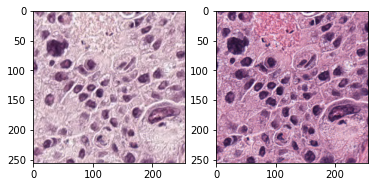

ssim: 0.32328937785901357
psnr: 12.779921811533022
vif: 0.0409039361484256


In [34]:
ink_patch, clean_patch, label_pair = pairdataset[idx]

clean_patch = np.asarray(clean_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)

fig, ax = plt.subplots(1,2)
print(label_pair)
ax[0].imshow(ink_patch)
ax[1].imshow(clean_patch)
plt.show()

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim(clean_patch, ink_patch)
psnr_without_normalization = psnr(clean_patch, ink_patch)
vif_without_normalization = pbvif(clean_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))


In [9]:
pbvif(clean_patch,clean_patch)

0.9999999999906294

0


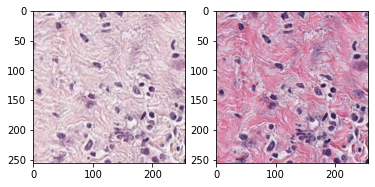

In [10]:
idx = np.random.randint(len(pairdataset))
ink_patch, clean_patch, label_pair = pairdataset[idx]

clean_patch = np.asarray(clean_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)

fig, ax = plt.subplots(1,2)
print(label_pair)
ax[0].imshow(ink_patch)
ax[1].imshow(clean_patch)
plt.show()

In [11]:
len(pairdataset)

5252

In [7]:
#Compare with single patch extraction annotation
ink_slide = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
clean_slide = str( Path(clean_path) / (str(df["Clean Slides"][0])+".svs" ) )
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}


singledataset = ExtractAnnotations(
        image_pth=ink_slide,
        annotation_dir=annotation_dir,
        renamed_label=ink_labelset,
        tile_h=TILE_H,
        tile_w=TILE_W,
        tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
        tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
        spacing=None,
        lwst_level_idx=LWST_LEVEL_IDX,
        mode="train",
        train_split=1,
        transform=TRANSFORM,
        threshold=0.7,
        sample_threshold=30
        )

Loading wsis.. 1/1: : 1it [01:37, 97.07s/it]


Len of pairwise slides: 2859
Len of single set: 2859
1


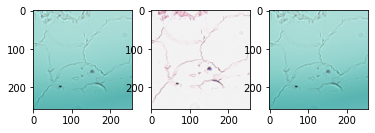

ssim: 0.013357551747010093
psnr: 11.184016828755855
vif: 0.01663175801600034


In [26]:
#Test slides
print(f"Len of pairwise slides: {len(dataset)}\nLen of single set: {len(singledataset)}")

idx = np.random.randint(len(dataset))
ink_patch, clean_patch, label_pair = dataset[idx]
ink_single_patch, label = singledataset[idx]

clean_patch = np.asarray(clean_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_single_patch = np.asarray(ink_single_patch.permute(1,2,0).numpy()*255,np.uint8)

fig, ax = plt.subplots(1,3)
print(label_pair)
ax[0].imshow(ink_patch)
ax[1].imshow(clean_patch)
ax[2].imshow(ink_single_patch)
plt.show()

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim(clean_patch, ink_patch)
psnr_without_normalization = psnr(clean_patch, ink_patch)
vif_without_normalization = pbvif(clean_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))


In [11]:
clean_patch*255

array([[[136., 100., 150.],
        [168., 129., 169.],
        [177., 132., 166.],
        ...,
        [245., 240., 239.],
        [243., 242., 243.],
        [243., 243., 244.]],

       [[131.,  94., 152.],
        [166., 123., 176.],
        [174., 125., 172.],
        ...,
        [245., 243., 244.],
        [245., 243., 244.],
        [243., 244., 245.]],

       [[125.,  89., 140.],
        [155., 113., 164.],
        [170., 123., 169.],
        ...,
        [244., 244., 246.],
        [244., 243., 245.],
        [243., 243., 245.]],

       ...,

       [[208., 182., 195.],
        [240., 192., 218.],
        [233., 190., 203.],
        ...,
        [244., 244., 245.],
        [243., 243., 245.],
        [244., 243., 245.]],

       [[250., 211., 211.],
        [234., 189., 211.],
        [232., 194., 213.],
        ...,
        [244., 244., 245.],
        [244., 244., 245.],
        [244., 244., 244.]],

       [[227., 177., 191.],
        [206., 171., 199.],
        [215., 1

## Ink Filter

In [3]:
slide_path = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
xml_path = str( Path(ink_slide_path) / Path("sedeen") / (str(df["Ink Slides"][0]) + ".session.xml" ))

label_set = {"Clean":"#00ff00ff", "Ink":"#ff0000ff"}

annotations = SedeenAnnotationParser(renamed_label=label_set, annular_color="#00ff00ff")
ext_annotation = annotations.parse(xml_path)

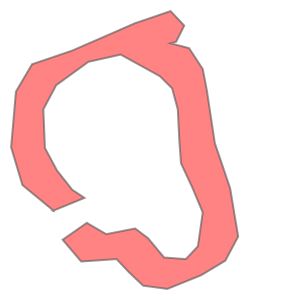

In [4]:
ext_annotation[0]._geometry

In [3]:
slide_path = [str( Path(ink_slide_path) / (str(df["Ink Slides"][i])+".svs" ) ) for i in range(len(df))]
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}

dataset_list = []
for slides in slide_path:
        dataset = ExtractAnnotations(
                image_pth=slides,
                annotation_dir=annotation_dir,
                renamed_label=ink_labelset,
                tile_h=TILE_H,
                tile_w=TILE_W,
                tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
                tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
                spacing=None,
                lwst_level_idx=LWST_LEVEL_IDX,
                mode="train",
                train_split=1,
                transform=TRANSFORM,
                threshold=0.7
                )
        dataset_list.append(dataset)

all_dataset = torch.utils.data.ConcatDataset(dataset_list)

Loading wsis.. 1/1: : 1it [00:57, 57.37s/it]
Loading wsis.. 1/1: : 1it [00:50, 50.43s/it]
Loading wsis.. 1/1: : 1it [01:20, 80.61s/it]
Loading wsis.. 1/1: : 1it [00:52, 52.33s/it]
Loading wsis.. 1/1: : 1it [00:27, 27.88s/it]
Loading wsis.. 1/1: : 1it [01:15, 75.10s/it]
Loading wsis.. 1/1: : 1it [01:13, 73.07s/it]
Loading wsis.. 1/1: : 1it [01:04, 64.87s/it]
Loading wsis.. 1/1: : 1it [01:18, 78.50s/it]
Loading wsis.. 1/1: : 1it [01:30, 90.59s/it]
Loading wsis.. 1/1: : 1it [01:01, 61.84s/it]
Loading wsis.. 1/1: : 1it [00:29, 29.79s/it]
Loading wsis.. 1/1: : 1it [01:09, 69.57s/it]
Loading wsis.. 1/1: : 1it [01:03, 63.36s/it]
Loading wsis.. 1/1: : 1it [01:56, 116.18s/it]


1


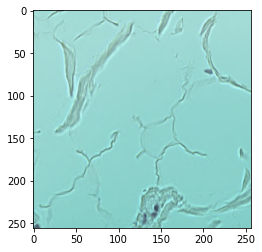

In [59]:
idx = 11
print(all_dataset[idx][1])
plt.imshow(all_dataset[idx][0].permute(1,2,0))

In [22]:
#About dataset
count = {0:0,1:0}
for i in range(len(all_dataset)):
    count[all_dataset[i][1]]+=1
print(count)

{0: 24084, 1: 17596}


In [4]:
#Ink filter model
# model_path = "/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_27Jul11_46_05_1.00.pt"
model_path = "/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_27Jul18_05_09_1.00.pt"

device = torch.device("cuda:3")
model = trainer.Model.create("ink")
model.load_model_weights(model_path,torch.device("cpu"))
model.to(device)

Mnist_model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [5]:
cm = torchmetrics.ConfusionMatrix(num_classes=2)
auroc = torchmetrics.AUROC(pos_label=1)

model.eval()
dataloader = torch.utils.data.DataLoader(all_dataset,batch_size=64)
index = []
with torch.no_grad():
    for i,data in enumerate(tqdm(dataloader)):
        img, label = data
        img = img.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.squeeze(predicted.cpu())
        idx = index.extend(64*i + torch.where(torch.abs(preds-label)==1)[0].numpy())
        soft = torch.nn.functional.softmax(outputs,dim=1).cpu()
        cm(preds,label)
        auroc(soft[:,1],label)
        # break

confusion = cm.compute()
tn = confusion[0,0]
fp = confusion[0,1]
fn = confusion[1,0]
tp = confusion[1,1]

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+fp+fn+tn)

auc = auroc.compute()


print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nAUCROC: {auc}\nConfusion matrix : {confusion}")


/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
  0%|          | 0/652 [00:00<?, ?it/s]/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
  4%|▎         | 23/652 [00:03<01:21,  7.72it/s]/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████| 652/652 [01:29<00:00,  7.31it/s]

Accuracy: 0.989659309387207
Precision: 0.9989535212516785
Recall: 0.9765287637710571
F1: 0.9876139163970947
AUCROC: 0.9974628686904907
Confusion matrix : tensor([[24066,    18],
        [  413, 17183]])


In [53]:
index[675]

22

33522
1


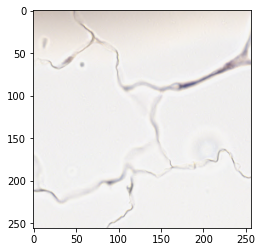

In [29]:
i = np.random.randint(len(index))
print(index[i])
print(all_dataset[index[i]][1])
plt.imshow(all_dataset[index[i]][0].permute(1,2,0))

In [10]:
label


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
torch.where(torch.abs(preds-label)==1)[0]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 51, 52, 53, 55, 56, 57, 58])

In [39]:
outputs


tensor([[ -5.8004,   5.8371],
        [ -0.7648,   0.8405],
        [  1.5153,  -1.3956],
        [  1.3976,  -1.3111],
        [  4.9750,  -4.7877],
        [ -1.9825,   2.0775],
        [ -3.9017,   3.9368],
        [ -0.4477,   0.5113],
        [  0.7774,  -0.7152],
        [  3.8345,  -3.6900],
        [  3.5905,  -3.4428],
        [  1.6420,  -1.5044],
        [  4.7756,  -4.5800],
        [  6.8575,  -6.6054],
        [  0.4877,  -0.3965],
        [ -2.8823,   2.9008],
        [ -4.7109,   4.7700],
        [  3.1955,  -3.0543],
        [  3.5677,  -3.4396],
        [ -0.1389,   0.1958],
        [ -2.1496,   2.1751],
        [ -3.9579,   3.9924],
        [ -0.8989,   0.9492],
        [  0.3678,  -0.2672],
        [  5.6456,  -5.4284],
        [ -0.2486,   0.3196],
        [ -5.2215,   5.2604],
        [ -5.2722,   5.3135],
        [ -3.0917,   3.1579],
        [ -0.1685,   0.2178],
        [ -2.3110,   2.3768],
        [ -4.6954,   4.7523],
        [ -5.9499,   5.9728],
        [ 

In [44]:
soft[:,1]

tensor([9.9999e-01, 8.3275e-01, 5.1618e-02, 6.2463e-02, 5.7560e-05, 9.8304e-01,
        9.9961e-01, 7.2292e-01, 1.8354e-01, 5.3937e-04, 8.8124e-04, 4.1236e-02,
        8.6468e-05, 1.4228e-06, 2.9230e-01, 9.9693e-01, 9.9992e-01, 1.9272e-03,
        9.0441e-04, 5.8290e-01, 9.8694e-01, 9.9965e-01, 8.6390e-01, 3.4638e-01,
        1.5511e-05, 6.3834e-01, 9.9997e-01, 9.9997e-01, 9.9807e-01, 5.9537e-01,
        9.9088e-01, 9.9992e-01, 9.9999e-01, 9.9995e-01, 6.0331e-02, 7.8173e-08,
        9.9979e-01, 7.1722e-01, 4.9565e-01, 9.9929e-01, 1.0000e+00, 5.8800e-04,
        2.9083e-06, 9.9971e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.2752e-05, 2.9654e-04, 2.2302e-05, 9.9796e-01, 9.9999e-01,
        9.9998e-01, 6.3618e-06, 2.8275e-05, 3.6888e-06, 9.9995e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [26]:
slides

'/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121669.svs'

In [27]:
slide_path

['/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121378.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121379.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121623.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121500.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121501.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121531.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122229.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122230.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122232.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121435.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121389.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121393.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121455.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121668.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Preci